# Entorno de pruebas de modelos de Deep Learning para segmentación semántica

# Instalación de librerías

In [1]:
import subprocess
import sys
def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
install_if_missing('torch')
install_if_missing('torchvision')
install_if_missing('segmentation-models-pytorch')
install_if_missing('transformers')

# Dependencias

In [2]:
import os
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from transformers import UperNetForSemanticSegmentation
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet101

# Configuración del entorno

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformación de imágenes y etiquetas

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    lambda x: (x * 255).long().squeeze(0)
])

# Carga de dataset [Pascal VOC](https://viso.ai/deep-learning/pascal-voc-dataset/) (Pattern Analysis, Statistical Modelling, and Computational Learning Visual Object Classes)

In [5]:
data_root = "./data"
dataset = torchvision.datasets.VOCSegmentation(root=data_root, year='2012', image_set='train', download=True,
                                               transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


# Carga de modelos
_Se pueden probar mas modelos como FCN y DeepLabV3 desde:_ https://pytorch.org/hub/research-models
_Se pueden probar mas modelos como Swin Transformer desde:_ https://huggingface.co/models?pipeline_tag=image-segmentation&sort=likes

In [ ]:
models = {
    "FCN": fcn_resnet50(pretrained=True).to(device),
    "DeepLabV3": deeplabv3_resnet101(pretrained=True).to(device),
    "Swin Transformer": UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-base").to(device)
}

# Inferencia con todos los modelos

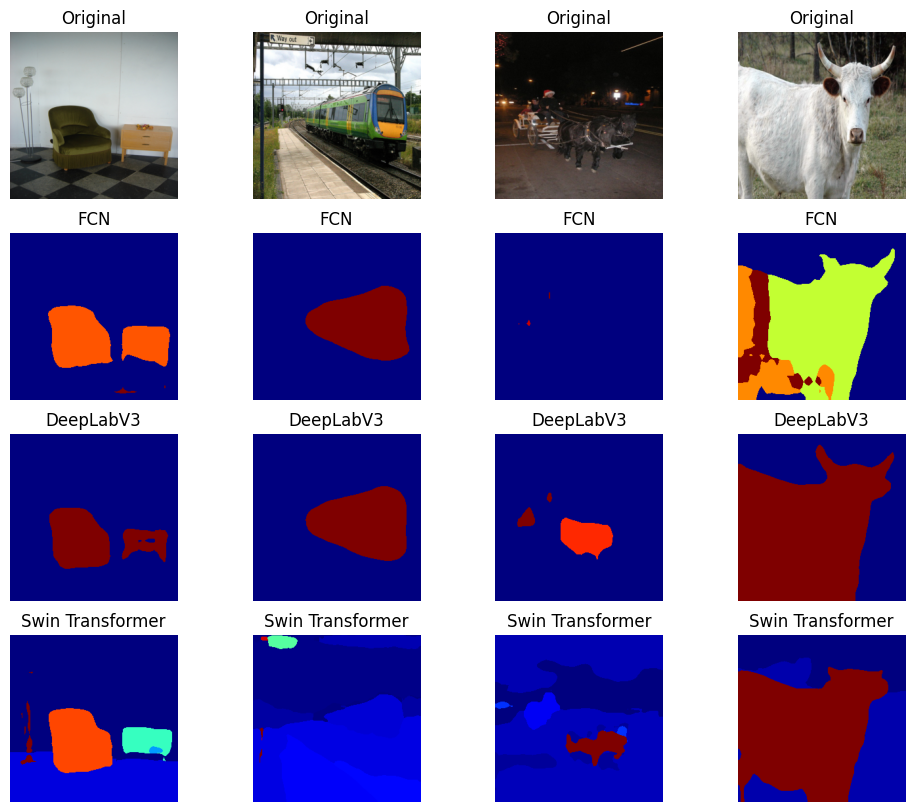

In [7]:
def test_models():
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    fig, axes = plt.subplots(len(models) + 1, len(images), figsize=(12, 10))

    # Imagen original
    for i, img in enumerate(images.cpu().numpy()):
        axes[0, i].imshow(img.transpose(1, 2, 0))
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

    # Predicciones
    for row, (name, model) in enumerate(models.items(), start=1):
        model.eval()
        with torch.no_grad():
            output = model(images)
            if isinstance(output, dict) and 'out' in output:
                output = output['out']
            elif hasattr(output, 'logits'):
                output = output.logits

            pred = torch.argmax(output, dim=1).cpu().numpy()

        for i in range(len(images)):
            axes[row, i].imshow(pred[i].squeeze(), cmap="jet")
            axes[row, i].set_title(name)
            axes[row, i].axis("off")

    plt.show()

test_models()

# Zona de pruebas
_Se pueden descargar más imágenes de prueba desde:_ https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset

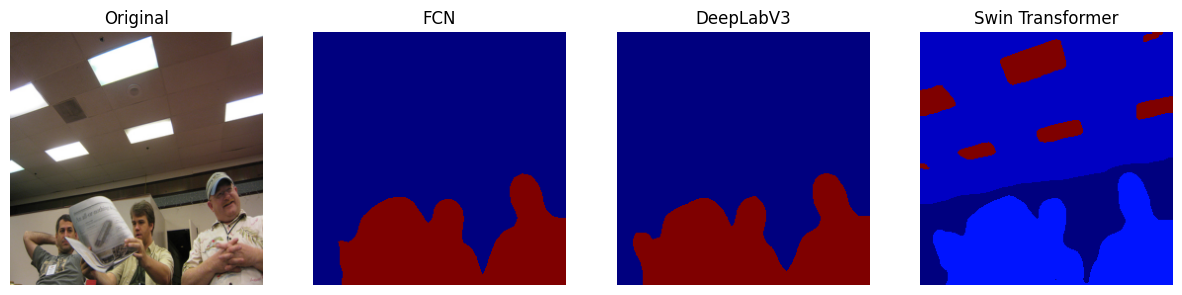

In [8]:
def infer_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)

    fig, axes = plt.subplots(1, len(models) + 1, figsize=(15, 5))

    # Mostrar imagen original
    axes[0].imshow(image.cpu().squeeze().permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Inferencia con cada modelo
    for i, (name, model) in enumerate(models.items(), start=1):
        model.eval()
        with torch.no_grad():
            if name == "SegFormer":
                inputs = feature_extractor(images=image, return_tensors="pt").to(device)
                output = model(**inputs).logits
            else:
                output = model(image)
                if isinstance(output, dict) and 'out' in output:
                    output = output['out']
                elif hasattr(output, 'logits'):
                    output = output.logits

            pred = torch.argmax(output, dim=1).cpu().squeeze().numpy()

        axes[i].imshow(pred.squeeze(), cmap="jet")
        axes[i].set_title(name)
        axes[i].axis("off")

    plt.show()

infer_image("/content/data/VOCdevkit/VOC2012/JPEGImages/2008_000380.jpg")